# 3.2 Decision Tree

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

import random
np.random.seed(123)
random.seed(123)

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score,recall_score,precision_score,f1_score, roc_auc_score


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Print all columns of a datafame
pd.set_option('display.max_columns', None)

# Table of Contents
* [Introduction](#introduction)
* [Data Loading](#data-loading)
* [Baseline Model](#baseline-model)
* [Model Optimization](#model-optimization)
    * [Hyperparameter Tuning](#hyperparameter-tuning)
    * [5-folds Cross Validation with Grid Search](#gridsearchcv)
* [Top Features](#top-features)

---

## Introduction <a id="introduction"></a>

**Streamlining Renewable Energy Site Selection with ML:
Predict the Suitability of Solar Energy Resources**

The goal of this project is to apply machine learning techniques to classify whether solar is suitable as the primary energy source for a location.

This can help energy decision makers and energy companies to simplify the complex site selection process, thereby accelerating the transition to clean and sustainable energy sources, ultimately contributing to the fight against climate change and energy crisis. 

This notebook will perform Decision Tree Classifier on the renewable power plants data with geospatial data. We will also perform model optimization by tuning the hyperparameters to find the best model with the highest recall and accuracy score.


---

## Data Loading <a id="data-loading"></a>

In [2]:
df = pd.read_csv("./data/capstone_data_cleaned_for_model.csv")

df_shape = df.shape
cat_cols = len(df.select_dtypes('object').columns)
num_cols = len(df.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df.duplicated().sum()}')
print(f'Percentage duplicate rows: {df.duplicated().mean()}% \n')

print(f'Total null values: {df.isna().sum().sum()}')
print(f'Percentage null vales: {df.isna().mean().sum()}% \n')

df.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7784
Columns: 6

Total duplicate rows: 0
Percentage duplicate rows: 0.0% 

Total null values: 0
Percentage null vales: 0.0% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       7784 non-null   float64
 1   WindSpeed       7784 non-null   float64
 2   SolarRadiation  7784 non-null   float64
 3   Elevation       7784 non-null   float64
 4   Slope           7784 non-null   float64
 5   isSolar         7784 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 365.0 KB


Number of categorical columns: 0
Number of numerical columns: 6


---

## Baseline Model <a id="baseline-model"></a>

Set up the model

In [3]:
X = df.drop(columns=['isSolar'])
y = df['isSolar']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (1557, 5)
Shape of train set: (6227, 5)


In [5]:
# Instantiate the model
base_DT = DecisionTreeClassifier(random_state=1)

# Fit the model
base_DT.fit(X_train, y_train)

# Scoring the model
base_DT.score(X_train, y_train)
base_DT.score(X_test, y_test)

print(f'Baseline DT Train result: {base_DT.score(X_train, y_train):.4f} accuracy.')
print(f'Baseline DT Test result: {base_DT.score(X_test, y_test):.4f} accuracy.')

Baseline DT Train result: 0.9998 accuracy.
Baseline DT Test result: 0.8028 accuracy.


We can see that the baseline model of decision tree has a better accuracy compared to the baseline logistic regression model. However, it shows significant overfitting.

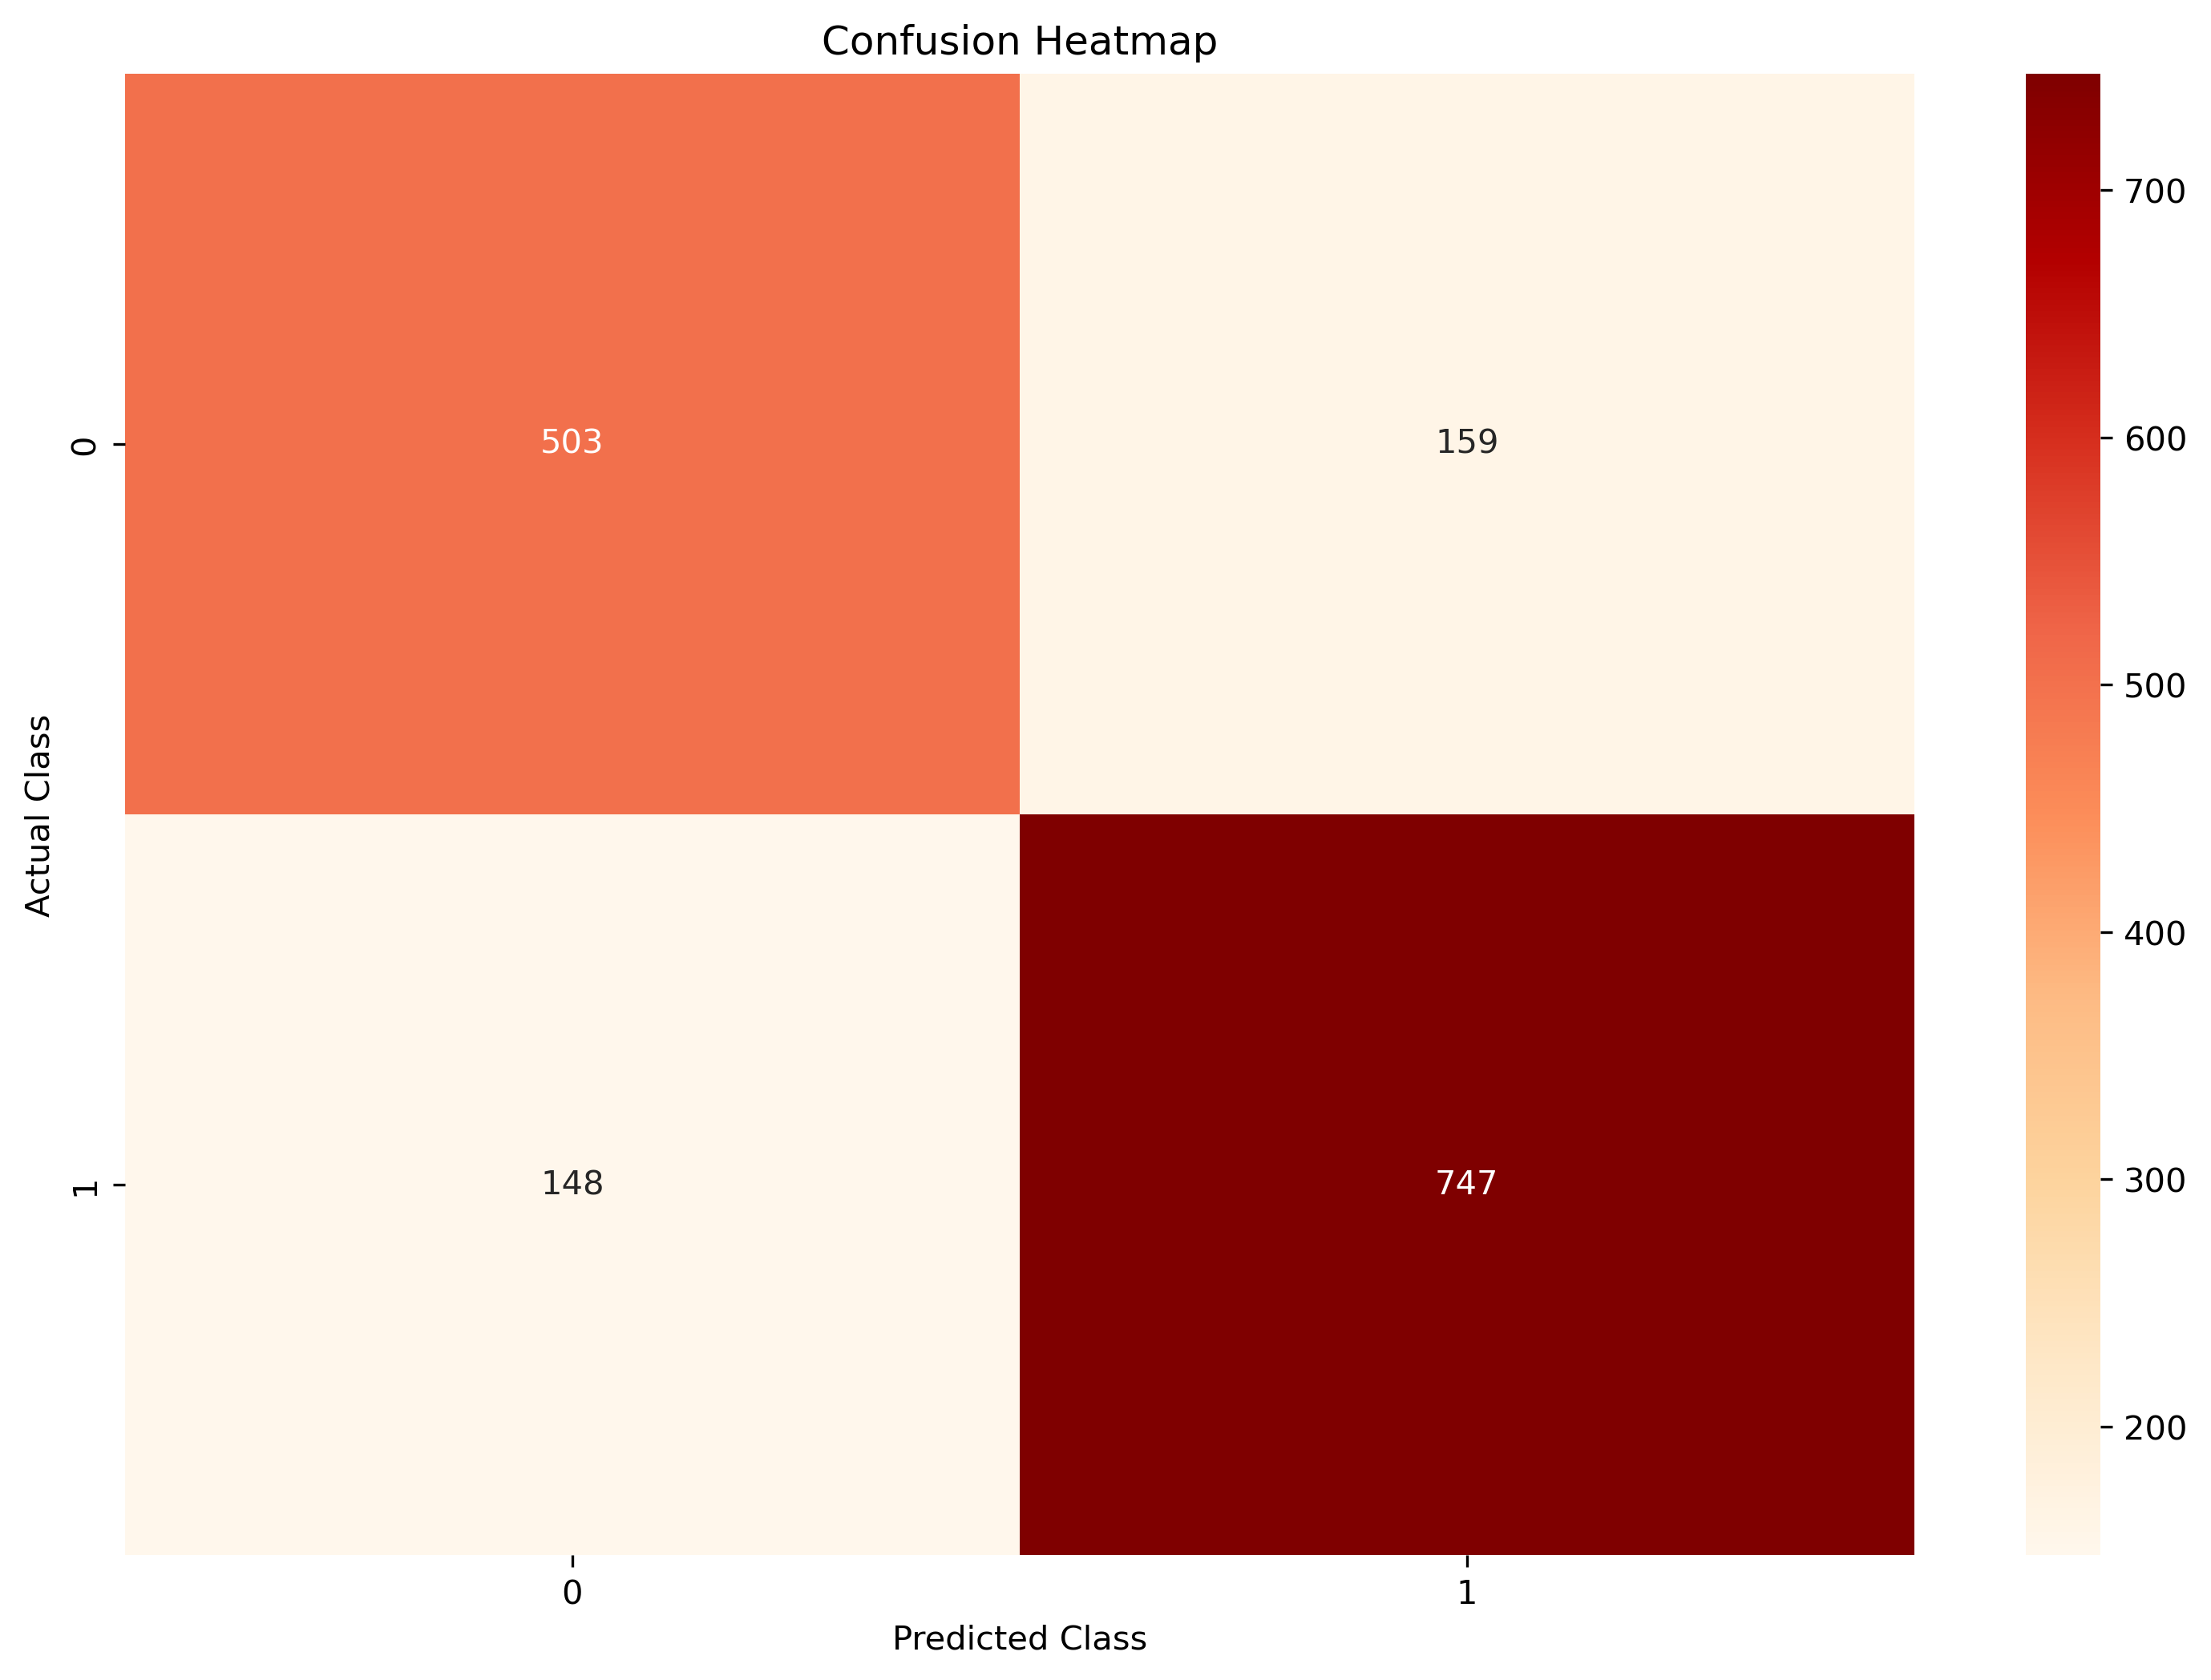

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       662
           1       0.82      0.83      0.83       895

    accuracy                           0.80      1557
   macro avg       0.80      0.80      0.80      1557
weighted avg       0.80      0.80      0.80      1557



In [6]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = base_DT.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [7]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8028259473346179
Precision Score : 0.8245033112582781
Recall Score : 0.8346368715083798
F1 Score : 0.8295391449194891
ROC AUC Score : 0.7972278013131024


In [8]:
# Create the score df
scores_df = {
    "ModelName": [],
    "Test Accuracy": [],
    "Test Precision": [],
    "Test Recall": [],
    "Test F1": [],
    "Test ROC AUC": []
}

def appendScores (model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred)

    scores_df["ModelName"].append(model_name)
    scores_df["Test Accuracy"].append(accuracy)
    scores_df["Test Precision"].append(precision)
    scores_df["Test Recall"].append(recall)
    scores_df["Test F1"].append(f1)
    scores_df["Test ROC AUC"].append(roc_auc)

    return pd.DataFrame(scores_df)

In [9]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Baseline_DT", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_DT,0.802826,0.824503,0.834637,0.829539,0.797228


---

## Model Optimization <a id="model-optimization"></a>

### Hyperparameter Tuning <a id="hyperparameter-tuning"></a>

In [10]:
# Split the data into remainder and test sets
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Print info on how the data has been split
print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=1, stratify=y_rem)

# Print info on how the data has been split
print(f'The train set has {len(X_train)} data points.')
print(f'The validation set has {len(X_val)} data points.')

The remainder set has 6227 data points.
The test set has 1557 data points.
The train set has 4981 data points.
The validation set has 1246 data points.


In [11]:
depths = list(range(1, 31, 1))
train_accuracies = []
validation_accuracies = []

for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    
    # Instantiate the model
    DT_model = DecisionTreeClassifier(max_depth=depth)

    # Fit the model to the train set
    DT_model.fit(X_train, y_train)
    
    # Append scores
    train_accuracies.append(DT_model.score(X_train, y_train))
    validation_accuracies.append(DT_model.score(X_val, y_val))

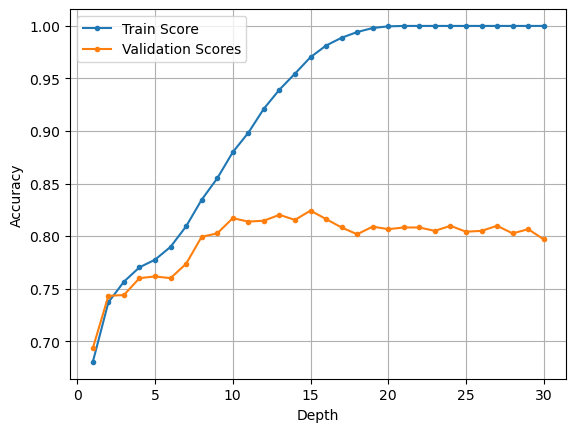

In [12]:
plt.figure()
plt.plot(depths, train_accuracies,label="Train Score",marker='.')
plt.plot(depths, validation_accuracies,label="Validation Scores",marker='.')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

As depth increases, the model overfits to the training set, due to the fact that the increasing number of decision boundaries makes the model separates more and more data points. At depth of 20, the model is able to separate all data points, reaching a train score of 100%.

The key is find a depth where the validation score is maximized while the train score is not too far away from it. Looking at the plot, I would say depth of 8 is the optimal depth, even though depth of 12 has the highest validation score.

In [13]:
best_depth = depths[np.argmax(validation_accuracies)]
print(f'The depth with the highest validation accuracy is: {best_depth}')

The depth with the highest validation accuracy is: 15


In [14]:
# Instantiate the model
DT_8 = DecisionTreeClassifier(max_depth=8,random_state=1)

# Fit the model
DT_8.fit(X_train, y_train)

# Scoring the model
DT_8.score(X_train, y_train)
DT_8.score(X_test, y_test)

print(f'DT with a depth of 8 achieved a Train result: {DT_8.score(X_train, y_train):.4f} accuracy.')
print(f'DT with a depth of 8 achieved a Test result: {DT_8.score(X_test, y_test):.4f} accuracy.')

DT with a depth of 8 achieved a Train result: 0.8346 accuracy.
DT with a depth of 8 achieved a Test result: 0.7765 accuracy.


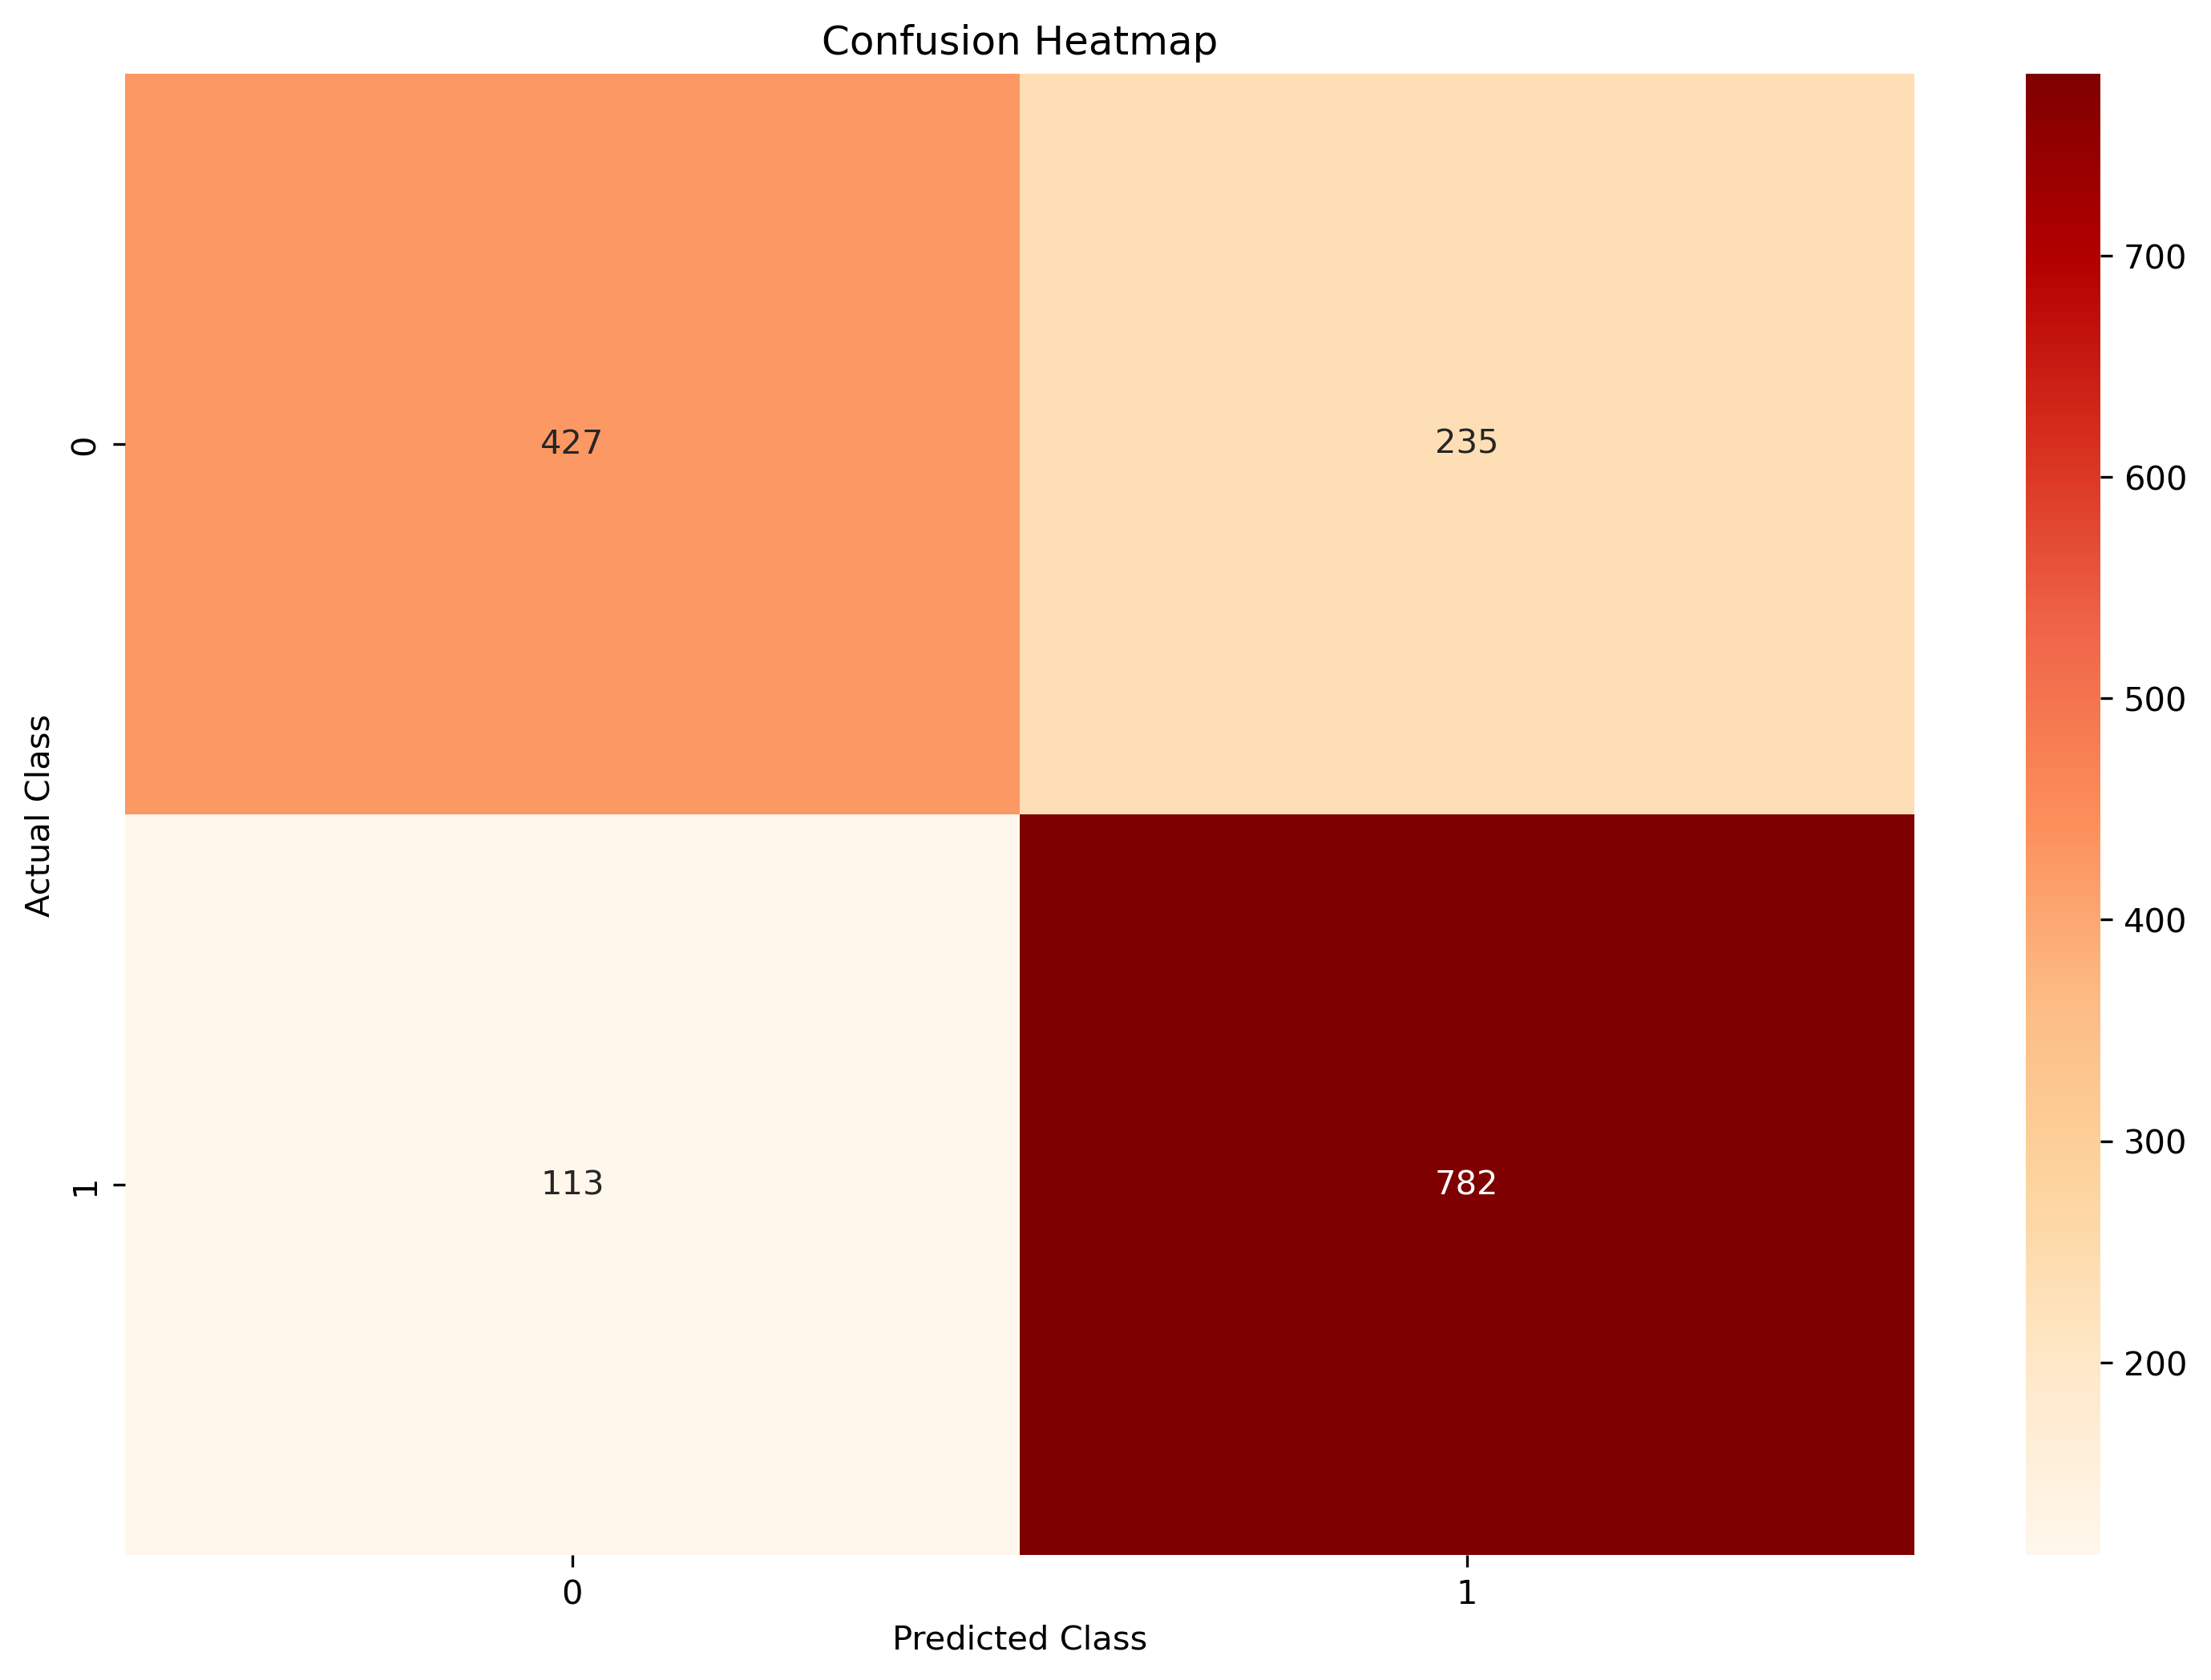

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       662
           1       0.77      0.87      0.82       895

    accuracy                           0.78      1557
   macro avg       0.78      0.76      0.76      1557
weighted avg       0.78      0.78      0.77      1557



In [15]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = DT_8.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [16]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.7764932562620424
Precision Score : 0.7689282202556539
Recall Score : 0.8737430167597765
F1 Score : 0.8179916317991632
ROC AUC Score : 0.7593790612499789


In [17]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Depth8_DT", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_DT,0.802826,0.824503,0.834637,0.829539,0.797228
1,Depth8_DT,0.776493,0.768928,0.873743,0.817992,0.759379


At depth 8, the Decision Tree model has lower accuracy compared to baseline model but a higher recall. We will take that as an improvement.

### 5-folds Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score

# Generate depths
depths = list(range(1, 31))

# Initialise list
cross_validation_scores = []

# Iteratively create models
for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    DT = DecisionTreeClassifier(max_depth=depth)
    cv_score = np.mean(cross_val_score(DT, X_rem, y_rem, cv = 5))
    cross_validation_scores.append(cv_score)

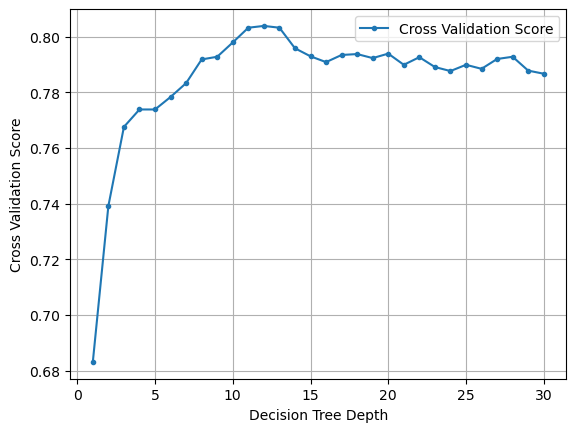

In [19]:
plt.figure()
plt.plot(depths, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel('Decision Tree Depth')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

In [20]:
optimum_depth = depths[np.argmax(cross_validation_scores)]
print(f'The optimum depth for the decision tree model is {optimum_depth}')

The optimum depth for the decision tree model is 12


In [21]:
# Instantiate the model
DT = DecisionTreeClassifier(max_depth=optimum_depth,random_state=1)

# Fit the model
DT.fit(X_train, y_train)

# Scoring the model
DT.score(X_train, y_train)
DT.score(X_test, y_test)

print(f'DT with a depth of {optimum_depth} achieved a Train result: {DT.score(X_train, y_train):.4f} accuracy.')
print(f'DT with a depth of {optimum_depth} achieved a Test result: {DT.score(X_test, y_test):.4f} accuracy.')

DT with a depth of 12 achieved a Train result: 0.9211 accuracy.
DT with a depth of 12 achieved a Test result: 0.8067 accuracy.


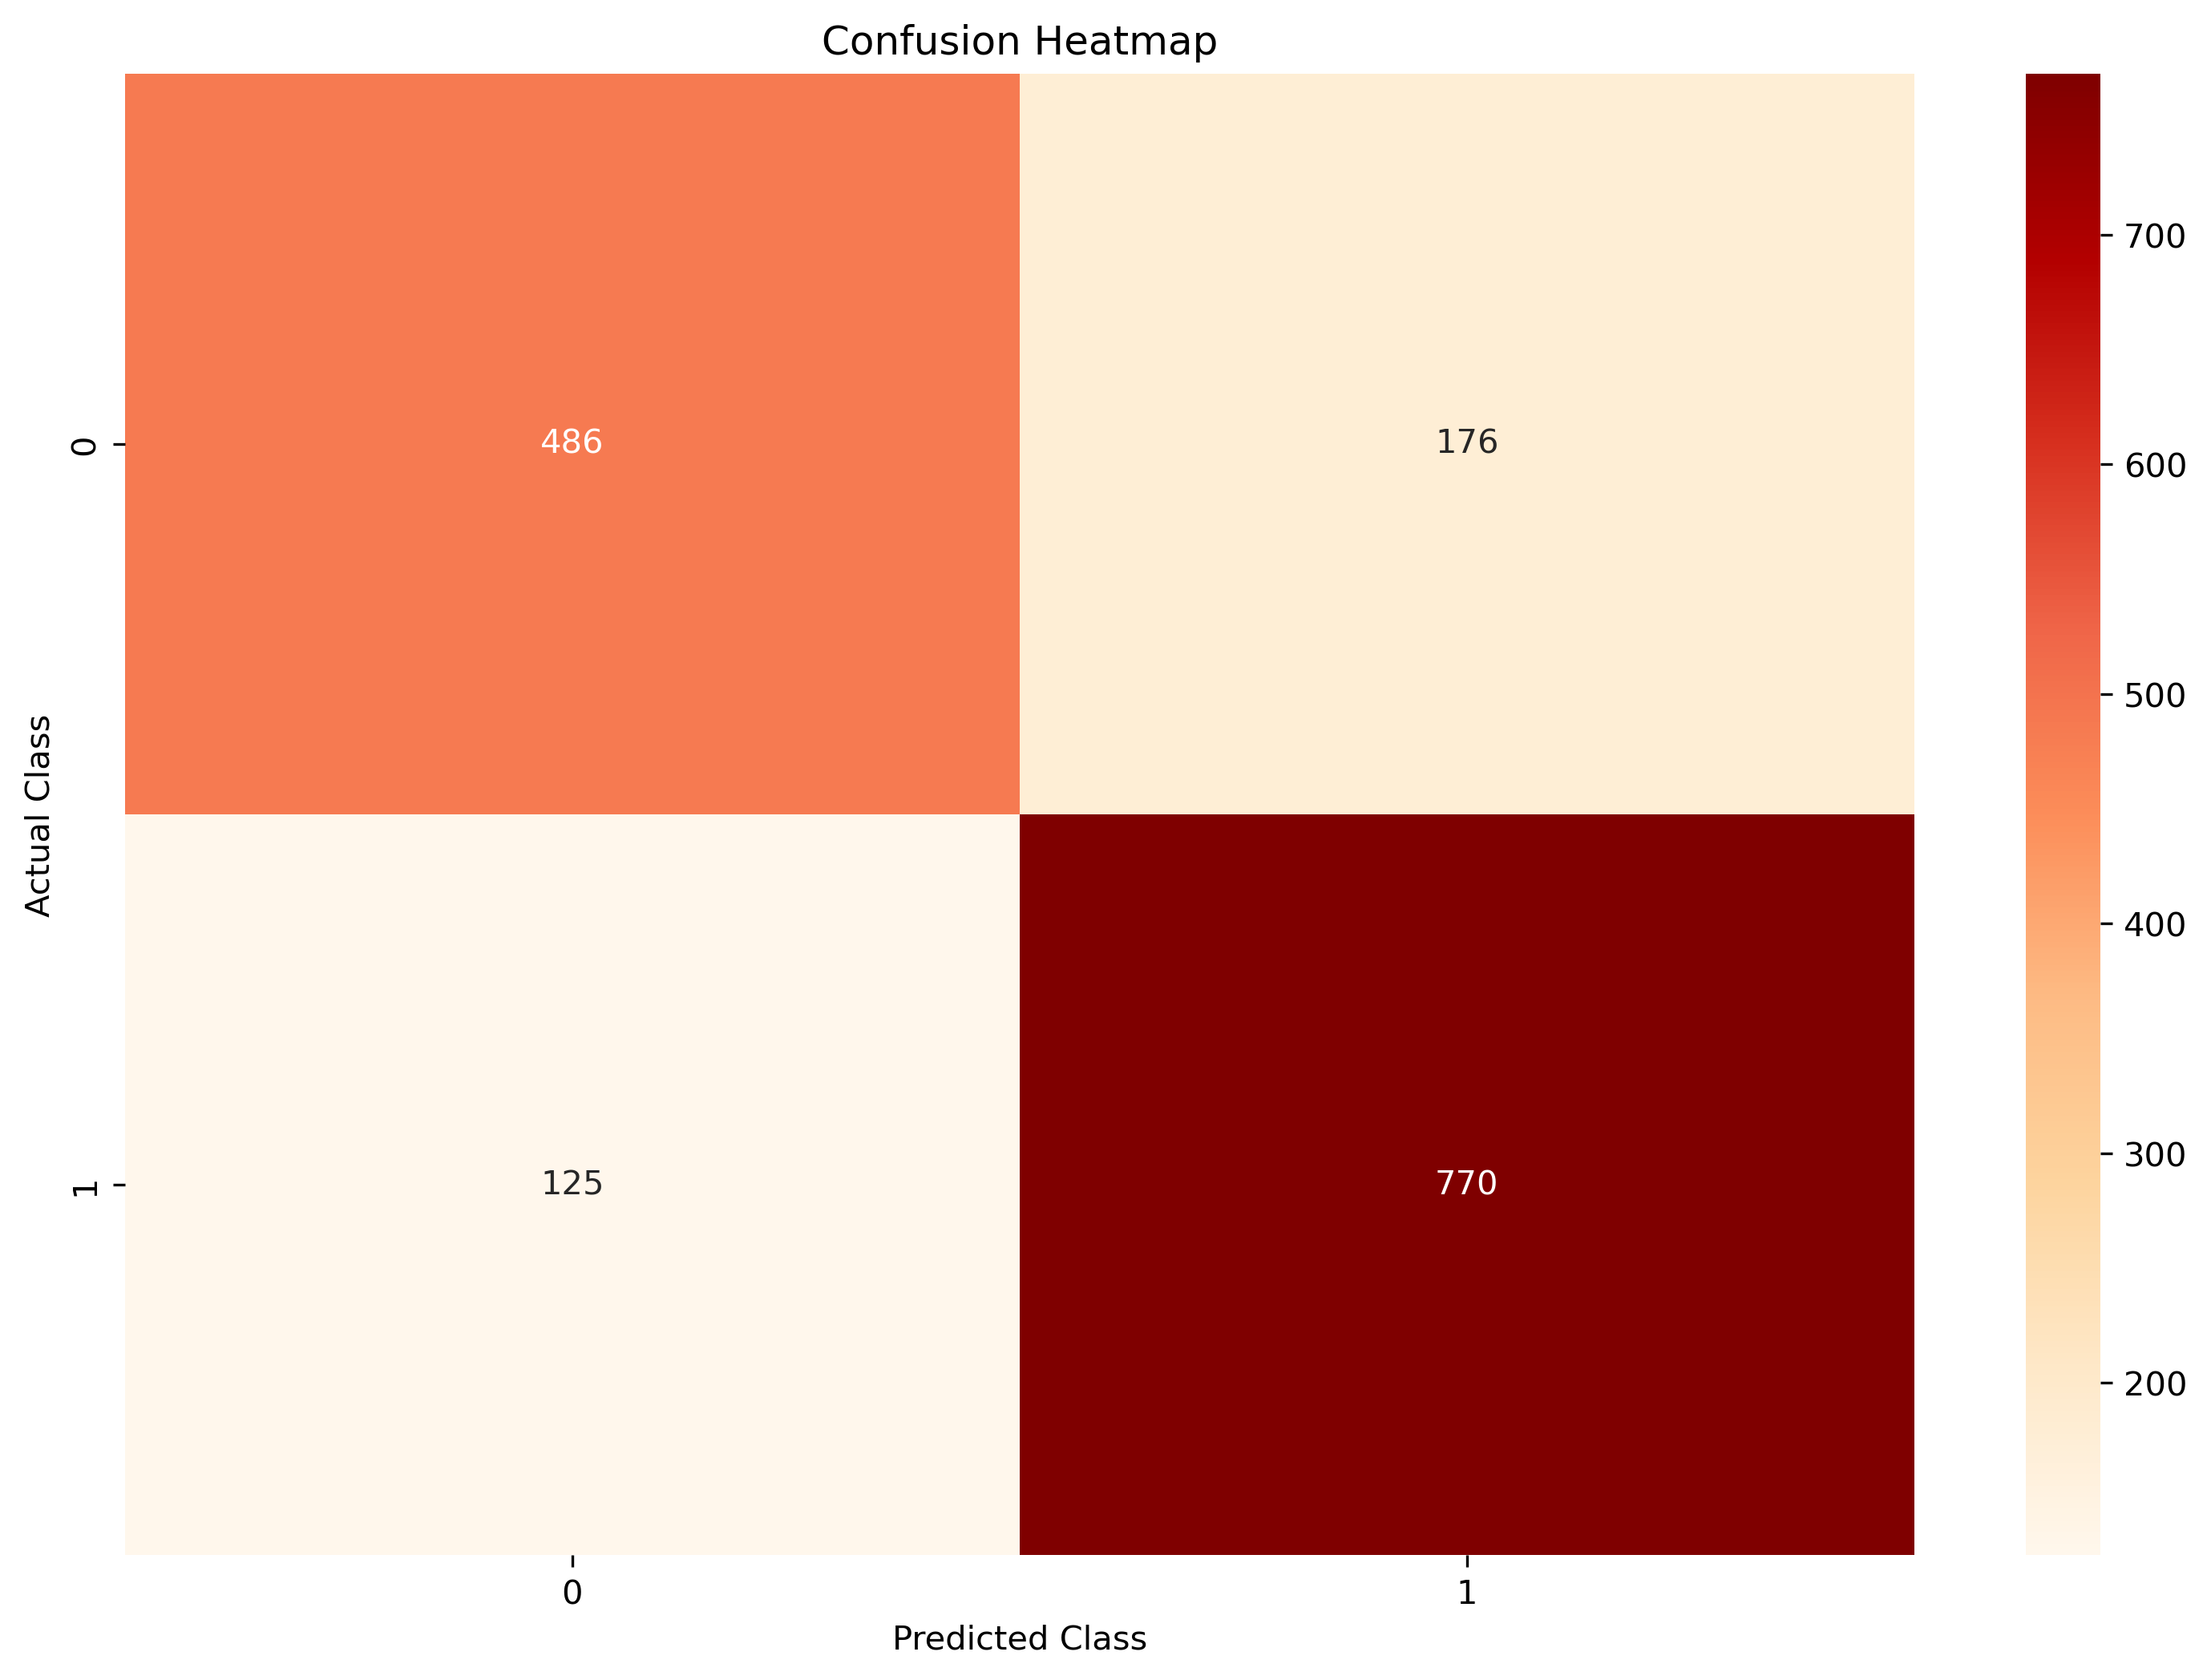

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       662
           1       0.81      0.86      0.84       895

    accuracy                           0.81      1557
   macro avg       0.80      0.80      0.80      1557
weighted avg       0.81      0.81      0.81      1557



In [22]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = DT.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [23]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8066795118818241
Precision Score : 0.813953488372093
Recall Score : 0.8603351955307262
F1 Score : 0.8365019011406845
ROC AUC Score : 0.797237084170197


In [24]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Depth12_DT", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_DT,0.802826,0.824503,0.834637,0.829539,0.797228
1,Depth8_DT,0.776493,0.768928,0.873743,0.817992,0.759379
2,Depth12_DT,0.806680,0.813953,0.860335,0.836502,0.797237


---

## 5-folds Cross Validaton with Grid Search <a id="gridsearchcv"></a>

The grid search that we are implementing at this stage is going to test multiple different hyperparameters for a decision tree model. The hyperparameters that we will be analysing are:

- Max depth: this will determine the depth of the tree. We will not be using an excessive amount of depths in the grid search as we have already found values in the range of 2 to 15.
- Critertion: this is the function used to measure the quality of a split.
- Splitter: this is the strategy used to choose the split at each node.
- Min samples leaf: this determines the minimum number of leaves that a node must have. By setting a maximum value, we are preventing a node from only having one lead - and consequently over-fitting.

In [25]:
from sklearn.metrics import balanced_accuracy_score

# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

estimators = [('scaler', StandardScaler()),
              ('model', DecisionTreeClassifier())

]

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
pipe = Pipeline(estimators, memory=cachedir)

depths = list(range(2, 15))

# Parameter grid
param_grid = [
    {'scaler': [StandardScaler(), MinMaxScaler(), None],
     'model__max_depth': depths,
     'model__criterion': ['gini', 'entropy'],
     'model__splitter': ['best', 'random'],
     'model__min_samples_leaf': list(range(2, 20, 2))

    }
]

# Instantiate the log reg grid search
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fittedGrid = grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 1404 candidates, totalling 7020 fits


In [26]:
fittedGrid.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 13,
 'model__min_samples_leaf': 8,
 'model__splitter': 'best',
 'scaler': StandardScaler()}

In [27]:
# Print the accuracies
print(f"The best decision tree's accuracy on the remainder set: {fittedGrid.score(X_rem, y_rem)}")
print(f"The best decision tree's accuracy on the test set: {fittedGrid.score(X_test, y_test)}")

The best decision tree's accuracy on the remainder set: 0.8775340311771672
The best decision tree's accuracy on the test set: 0.7950648956100526


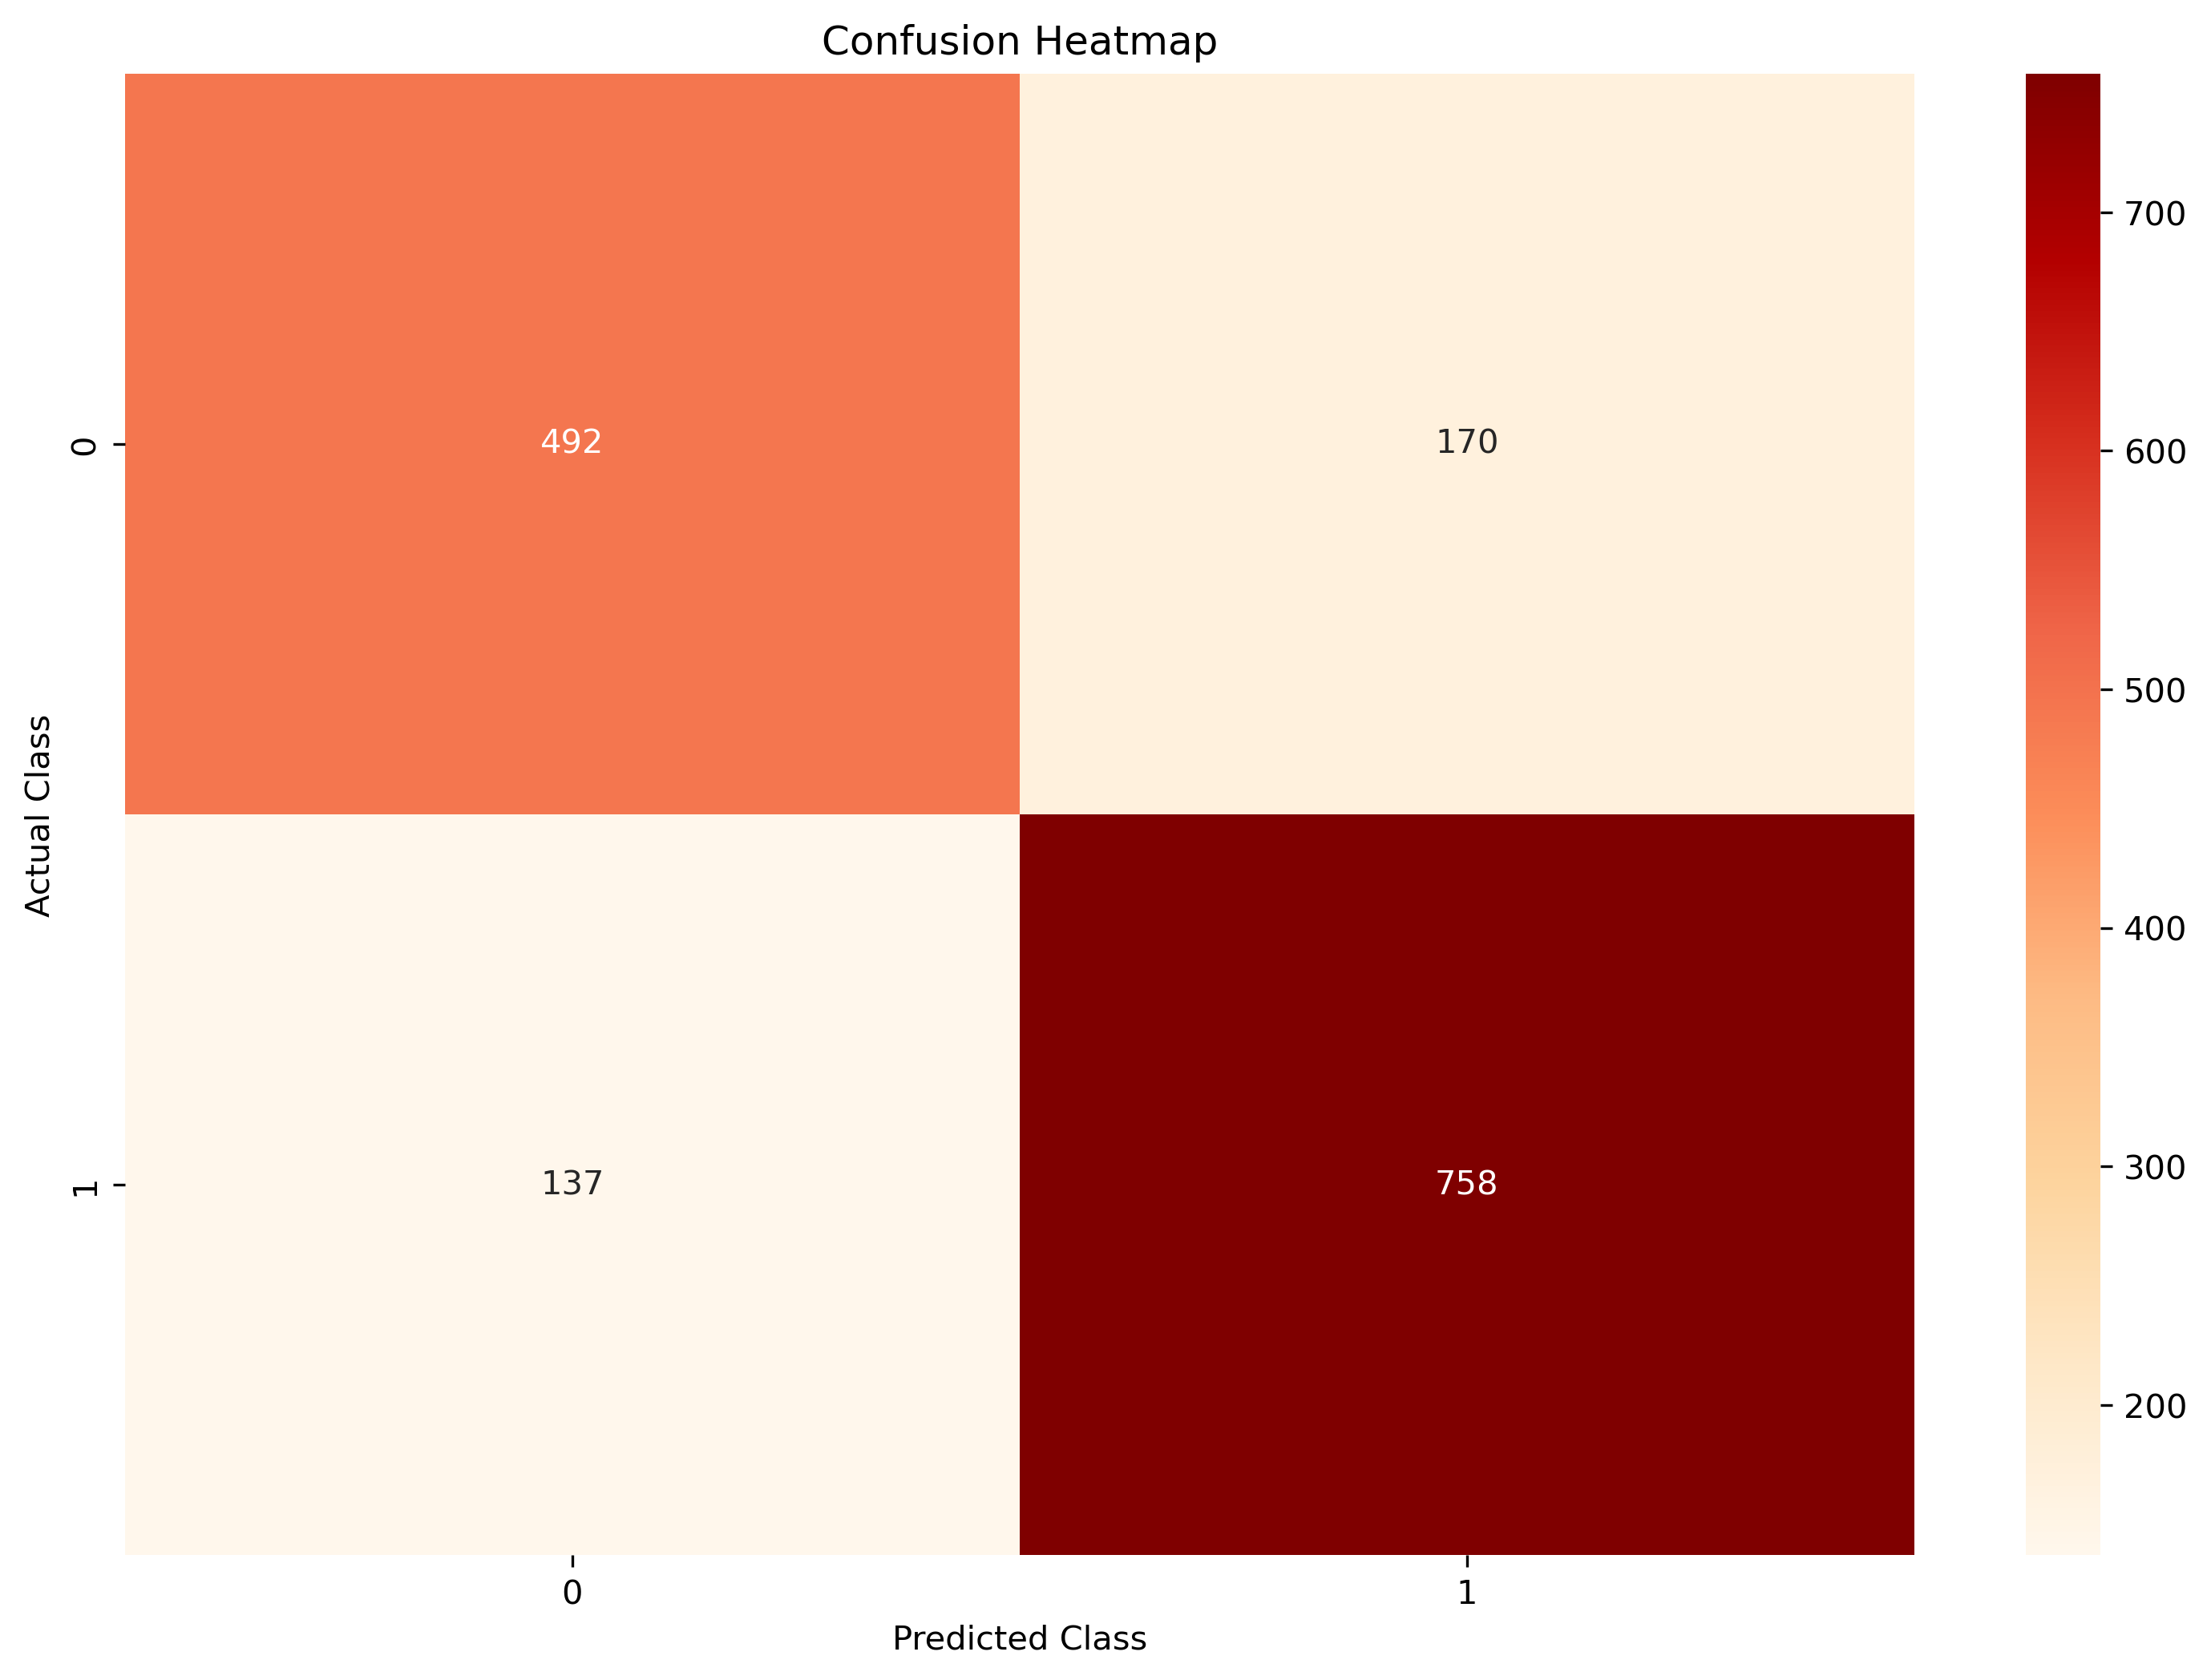

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       662
           1       0.82      0.85      0.83       895

    accuracy                           0.80      1557
   macro avg       0.80      0.80      0.80      1557
weighted avg       0.80      0.80      0.80      1557



In [28]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = fittedGrid.best_estimator_.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [29]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8028259473346179
Precision Score : 0.8168103448275862
Recall Score : 0.846927374301676
F1 Score : 0.8315962698848053
ROC AUC Score : 0.7950648956100524


In [30]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Depth12_GridSearch_DT", y_test, y_pred)

,ModelName,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC
0,Baseline_DT,0.802826,0.824503,0.834637,0.829539,0.797228
1,Depth8_DT,0.776493,0.768928,0.873743,0.817992,0.759379
2,Depth12_DT,0.806680,0.813953,0.860335,0.836502,0.797237
3,Depth12_GridSearch_DT,0.802826,0.816810,0.846927,0.831596,0.795065


Using GridSearch didn't help us to get a better model compared to model we got previously. I will instead take the Decision Tree at depth of 8 as the best model here as it has better recall scores and less overfitted.

In [31]:
best_model = DT_8

## Top Features <a id="top-features"></a>

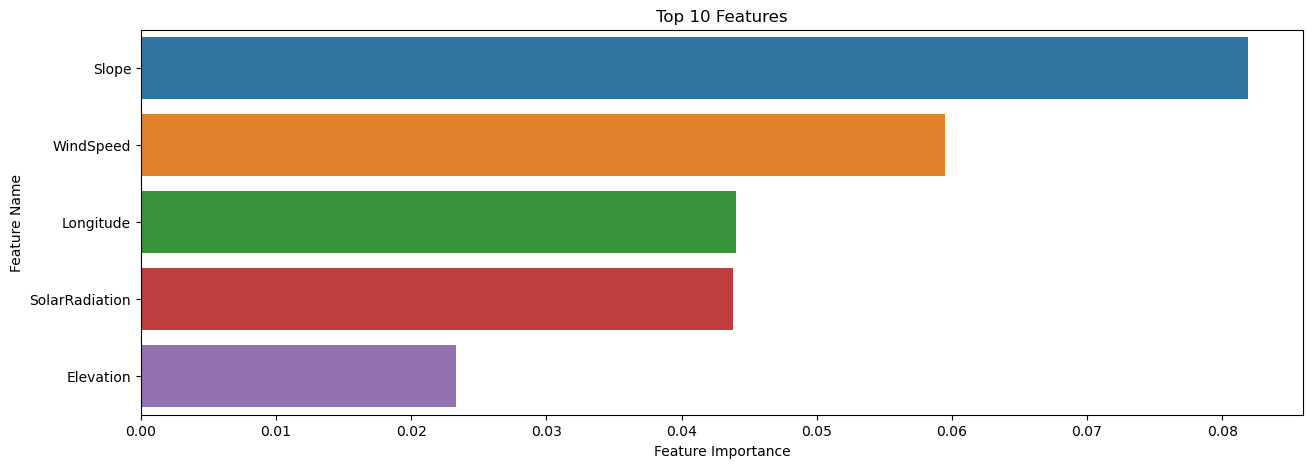

In [32]:
importances = best_model.tree_.compute_feature_importances(normalize=False)
importances_df = pd.DataFrame({'Variable': X.columns,
                                'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 5))
plt.title('Top 10 Features')
sns.barplot(x='Importance', y='Variable', data=importances_df.head(10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

[Text(967.1263966480448, 1454.4444444444443, 'Slope <= 3.346\ngini = 0.489\nsamples = 4981\nvalue = [2118, 2863]\nclass = Solar'),
 Text(586.6620111731844, 1283.3333333333333, 'WindSpeed <= 8.204\ngini = 0.45\nsamples = 4031\nvalue = [1380, 2651]\nclass = Solar'),
 Text(332.838687150838, 1112.2222222222222, 'SolarRadiation <= 3.771\ngini = 0.408\nsamples = 3627\nvalue = [1037, 2590]\nclass = Solar'),
 Text(139.62988826815644, 941.1111111111111, 'Slope <= 1.178\ngini = 0.476\nsamples = 289\nvalue = [176, 113]\nclass = Non-solar'),
 Text(84.42737430167598, 770.0, 'Longitude <= -78.967\ngini = 0.456\nsamples = 71\nvalue = [25, 46]\nclass = Solar'),
 Text(38.96648044692738, 598.8888888888889, 'Longitude <= -122.519\ngini = 0.453\nsamples = 26\nvalue = [17, 9]\nclass = Non-solar'),
 Text(17.318435754189945, 427.7777777777778, 'SolarRadiation <= 3.59\ngini = 0.375\nsamples = 8\nvalue = [2, 6]\nclass = Solar'),
 Text(8.659217877094973, 256.66666666666674, 'gini = 0.0\nsamples = 2\nvalue = [2,

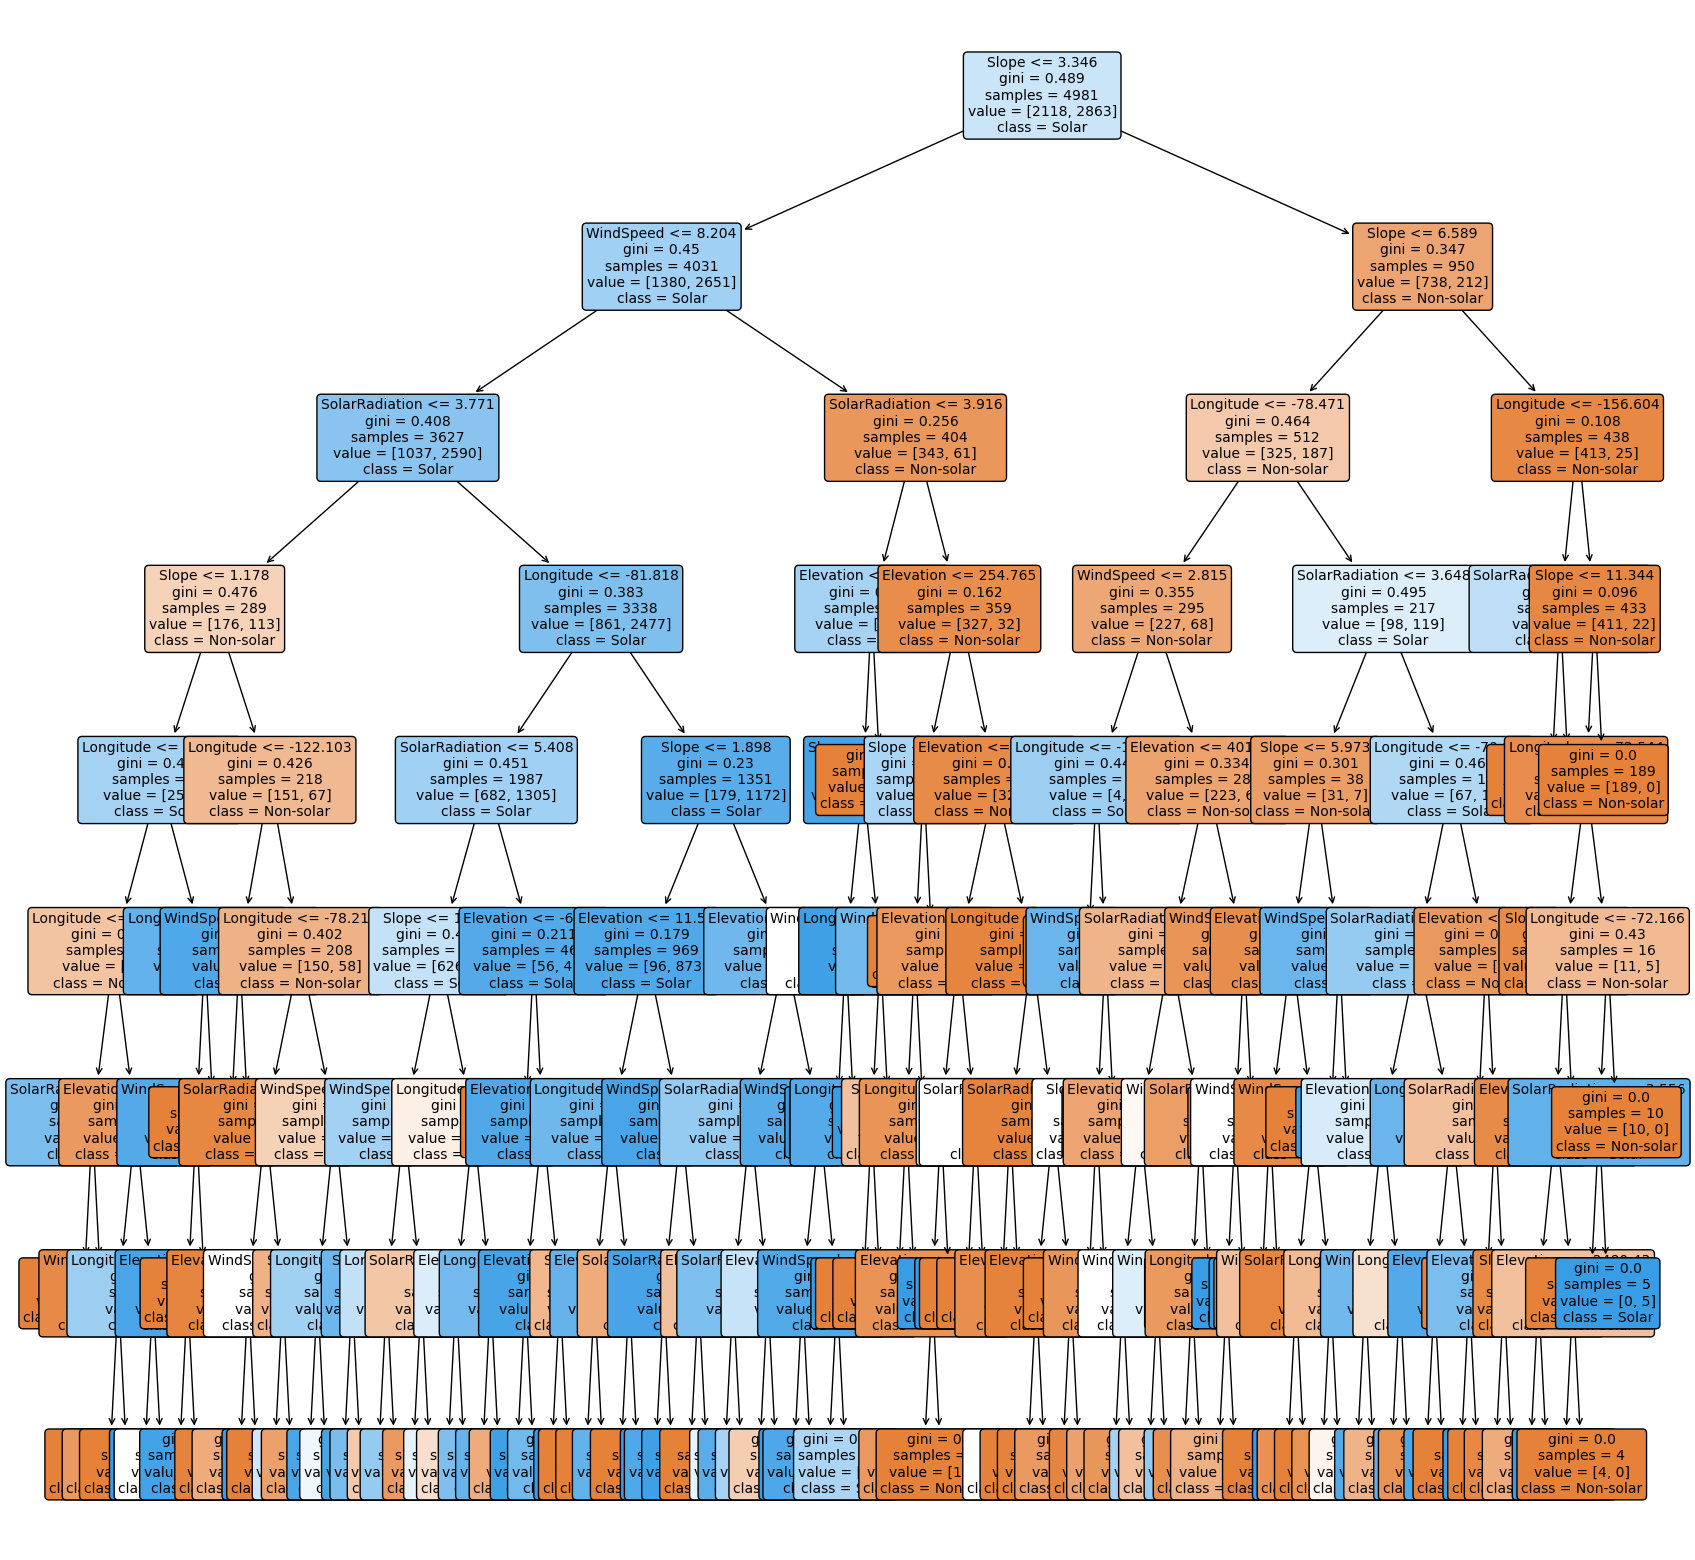

In [39]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20,20))

plot_tree(best_model, 
          feature_names=X.columns, 
          class_names=["Non-solar", "Solar"],
          rounded=True,
          impurity=True,
          filled=True,
          ax=ax,
          fontsize=10)

We can see that locations with slope less than 3.346m and Wind Speed less than 8.2 will be considered as suitable for solar energy by Decision Tree.

---

### Saving the model

In [34]:
import pickle
pickle.dump(best_model, open('./models/dt_model.pkl', 'wb'))

### Loading the model

In [ ]:
import pickle
best_model = pickle.load(open('models/dt_model.pkl', 'rb'))